In [6]:
import numpy as np
from numpy import pi
from scipy import linalg as la
import numpy as np
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
# Some rotation utility functions

def calculate_rotation_matrix(n,sin,cos):
    '''
    Rotatation matrix around a normal vector n
    By angle theta, passed in as <sin> = sin(theta) and
    <cos> = cos(theta)
    '''
    assert np.abs(la.norm(n) - 1) < 1e-3, 'n must be a unit vector'
    
    n1 = n[0]
    n2 = n[1]
    n3 = n[2]
#     cos = np.sqrt(1-sin**2)
    R = np.zeros((3,3))
    R[0,0] = cos + n1**2 * (1-cos)
    R[0,1] = n1*n2*(1-cos) - n3*sin
    R[0,2] = n1*n3*(1-cos) + n2*sin
    R[1,0] = n1*n2*(1-cos) + n3*sin
    R[1,1] = cos + n2**2 * (1-cos)
    R[1,2] = n2*n3*(1-cos) - n1*sin
    R[2,0] = n1*n3*(1-cos) - n2*sin
    R[2,1] = n2*n3*(1-cos) + n1*sin
    R[2,2] = cos + n3**2 * (1-cos)
    
    return R

def rotate_to_z(v):
    '''
    Takes a vector v and rotates it to be aligned with the z axis
    '''
    normv = la.norm(v)
    v = v / normv
    z = np.array([0,0,1])
    # normal vector between v and z
    n = np.cross(v,z)
    # sin of angle by which to rotate
    sin = la.norm(n)
    cos = np.dot(v,z)
    n = n / sin
    R = calculate_rotation_matrix(n,sin,cos)
    vz = R @ v * normv
    return vz,n,sin

def rotate_z_to_v(z_noisy,v):
    '''
    Takes vector z_noisy and rotates it according to the same rotation
    that would align z with v
    '''
    z = np.array([0,0,1])
    n = np.cross(z,v)
    sin = la.norm(n)
    n = n / sin
    cos = np.dot(z,v)
    R = calculate_rotation_matrix(n,sin,cos)
    v_noisy = R @ z_noisy
    return v_noisy
    

In [59]:
def distribute_sensors(n_sensors,lb=5,ub=15):
    '''
    distribute the sensors in a hollowed sphere
    '''
    r = np.random.uniform(lb,ub,n_sensors)
    theta = np.random.uniform(0,np.pi,n_sensors)
    phi = np.random.uniform(0,2*np.pi,n_sensors)
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    S = np.vstack((x,y,z))
    return S

def sensor_proj(S):
    '''
    calculate projection matrices for the sensors
    NOTE: Should this be done using V (noisy) instead of S (not noisy)?
    '''
    _,n_sensors = S.shape
    P = np.zeros((3,4,n_sensors))
    for i in range(n_sensors):
        p = S[:,i]
        tmpn = np.cross([0,0,1],p)
        tmpn = tmpn / la.norm(tmpn)
        up = np.cross(p,tmpn)
        up = up / la.norm(up)
        
        L = -p / la.norm(p)
        tmpa = np.cross(L,up)
        tmpa /= la.norm(tmpa)
        tmpb = np.cross(tmpa,L)
        R = np.r_[tmpa,tmpb,-L].reshape((3,3))
        T = -R @ p
        P[:,:,i] = np.c_[R,T]
    return P
        

def form_V(S,sig_a=0,sig_b=0,a=np.array([1,0,0]),b=np.array([0,1,0])):
    S_norm = la.norm(S,axis=0)
    V = -S / S_norm
    V = add_noise(a,b,sig_a,sig_b,V)
    return V
    
def form_G(S,V):
    '''
    Helper function for least squares triangulation
    G is the geometry matrix
    V1 is a matrix of unit pointing vectors
    '''
    _,n = S.shape
    I = np.tile(np.eye(3),(n,1))
    S_norm = la.norm(S,axis=0)
    V_temp = np.tile(V,(n,1))
    id_temp = np.kron(np.eye(n),np.ones((3,1)))
    V2 = V_temp * id_temp
    G = np.c_[I,V2]
    return G

def add_noise(a, b, sig_a, sig_b, V):
    '''
    Add noise to V along axes a, b
    Characterized by standard deviations sig_a, sig_b
    Assuming that noise is white
    For the nth sensor, assume that z points in the direction of v_n
    y is positive in the camera-up direction
    x is positive such that x cross y = z (will be in the left direction)
    a and b should be orthogonal
    '''
    assert np.dot(a,b) < 1e-3, "a and b must be orthogonal"
    _,N = V.shape
    V_noisy = np.zeros_like(V)
    z = np.array([0,0,1])
    # normal vectors for rotation
    n_a = np.cross(z,a)
    n_b = np.cross(z,b)
    for i in range(N):
        # randomly perturb z along a, b
        theta_a = np.random.normal(0,sig_a,1)
        R_a = calculate_rotation_matrix(n_a,np.sin(theta_a),np.cos(theta_a))
        theta_b = np.random.normal(0,sig_b,1)
        R_b = calculate_rotation_matrix(n_b,np.sin(theta_b),np.cos(theta_b))
        z_noisy = R_a @ R_b @ z
        
        v = V[:,i]
        assert np.abs(la.norm(v) - 1) <= 1e-3, "V must be composed of unit column vectors"
        V_noisy[:,i] = rotate_z_to_v(z_noisy, v)
    
    return V_noisy

def plot_pointing_vectors(ax, S, V):
    _,N = V.shape
    for i in range(N):
        # get endpoints
        ep1 = S[:,i]
        l = la.norm(ep1)*1.5
        ep2 = ep1 + l * V[:,i]
        ax.plot((ep1[0],ep2[0]),(ep1[1],ep2[1]),(ep1[2],ep2[2]),linewidth=1,zorder=-1)
        ax.scatter(S[0,:],S[1,:],S[2,:],c = 'm')

In [82]:
def decompose(P):
    '''
    Decomposes a camera projection matrix P into K, R, and t
    '''
    M = P[:3,:3]
    Minv = la.inv(M)
    C = -Minv @ P[:3,3]
    
    # R must be orthogonal
    # K must be upper triangular
    K,R = la.rq( M )
    
    # Enforce that K has positive diagonals
    T = np.diag( np.sign( np.diag(K) ) )
    K = K @ T
    K = K / K[2,2]
    R = T @ R
    
    t = -R @ C
    
    return K,R,t

def triangulate_l2(u1,u2,P1,P2):
    K,R1,t1 = decompose(P1)
    _,R2,t2 = decompose(P2)

    # Relative rotation and translation that transform
    # a point from C1 to C2
    R = R2 @ R1.T
    t = -R2 @ R1.T @ t1 + t2
    
    # precompute for speedup
    Kinv = la.inv(K)
    
    m1 = R @ Kinv @ u1
    m2 = Kinv @ u2
    
    # unit vectors
    m1hat = m1 / la.norm(m1)
    m2hat = m2 / la.norm(m2)
    that = t / la.norm(t)
    
    # SVD matrix
    MT = np.vstack( (m1,m2) )
    P = np.eye(3) - np.outer(that,that)
    A = MT @ P
    _,_,Vh = la.svd(A)
    nhat = Vh[1]
    
    # corrections of m1 and m2
    m1p = m1 - np.dot(m1, nhat) * nhat
    m2p = m2 - np.dot(m2, nhat) * nhat
#     print(m1p,m2p)
    
    Rf1p = m1p
    f2p = m2p
#     print( np.dot( f2p, np.cross( t, Rf1p ) ) )
    z = np.cross(f2p, Rf1p)
    
    X1 = t + np.dot( z, np.cross(t, f2p) ) / la.norm(z)**2 * Rf1p
    X2 = np.dot( z, np.cross(t, Rf1p) ) / la.norm(z)**2 * f2p
    return R2.T @ (X2-t2)

def triangulate_l1(u1,u2,P1,P2):
    K,R1,t1 = decompose(P1)
    _,R2,t2 = decompose(P2)
    C1 = -R1.T @ t1
    C2 = -R2.T @ t2
#     print(C1)
    

    # Relative rotation and translation that transform
    # a point from C1 to C2
    R = R2 @ R1.T
    t = -R2 @ R1.T @ t1 + t2
    
    # precompute for speedup
    Kinv = la.inv(K)
    
    f1 = Kinv @ u1
#     print(f1)
#     f1 /= f1[2]
    f2 = Kinv @ u2
#     f2 /= f2[2]
#     print(np.dot( f2, np.cross(t, R @ f1) ))
    
    m1 = R @ f1
    m2 = f2
    
    # unit vectors
    m1hat = m1 / la.norm(m1)
    m2hat = m2 / la.norm(m2)
    
    # normals
    n1 = np.cross(m1, t)
    n2 = np.cross(m2, t)
    n1hat = n1 / la.norm(n1)
    n2hat = n2 / la.norm(n2)
    
    # corrections of m1 and m2
    if la.norm( np.cross(m1, t) ) <= la.norm( np.cross(m2, t) ):
        m1p = m1 - np.dot(m1, n2hat) * n2hat
        m2p = m2
    else:
        m1p = m1
        m2p = m2 - np.dot(m2, n1hat) * n1hat
#     print(m1p,m2p)
    
    Rf1p = m1
    f2p = m2
#     print( np.dot( f2p, np.cross( t, Rf1p ) ) )
    z = np.cross(f2p, Rf1p)
    
    X1 = t + np.dot( z, np.cross(t, f2p) ) / la.norm(z)**2 * Rf1p
    X2 = np.dot( z, np.cross(t, Rf1p) ) / la.norm(z)**2 * f2p
#     print(R1.T @ X1 + C1)
    return R2.T @ (X2-t2)

In [70]:
def ls_triangulate(S,V):
    _,n = S.shape
    G = form_G(S,V)
    r0 = np.reshape(S.T,(3*n,1))
    rt,_,_,_ = la.lstsq(G,r0)
    rt = rt.flatten()
    r = rt[:3]
    t = rt[3:]
    return r,t
def sensor_proj(S):
    '''
    calculate projection matrices for the sensors
    assumes that the pointing vector, up vector, and z axis will always be coplanar
    and that the z component of up will be positive
    NOTE: Should this be done using V (noisy) instead of S (not noisy)?
    NOTE: does not work for sensor aligned in the z direction
    '''
    _,n_sensors = S.shape
    P = np.zeros((3,4,n_sensors))
    for i in range(n_sensors):
        p = S[:,i]
        tmpn = np.cross([0,0,1],p)
        tmpn = tmpn / la.norm(tmpn)
        up = np.cross(p,tmpn)
        up = up / la.norm(up)
        
        L = -p / la.norm(p)
        tmpa = np.cross(L,up)
        tmpa /= la.norm(tmpa)
        tmpb = np.cross(tmpa,L)
        R = np.r_[tmpa,tmpb,-L].reshape((3,3))
        T = -R @ p
#         print(R)
#         print(T)
        P[:,:,i] = np.c_[R,T]
    return P

In [101]:
def skew_symm(x):
    Sx = np.zeros((2,3))
    Sx[0,1] = -x[2]
    Sx[0,2] = x[1]
    Sx[1,0] = x[2]
    Sx[1,2] = -x[1]
    return Sx

def calculate_ellipsoid_covariance(s1,s2,a1,a2,b1,b2,sig_a1,sig_a2,sig_b1,sig_b2,X):
    '''
    Finds covariance matrix of error ellipsoid for calculating triangulation
    given two sensors
    Takes in a,b which are major and minor error axes in camera coordinates
    sig_a,sig_b which are error variances 
    '''
    C1 = np.diag([sig_a1,sig_b1,0])
    C2 = np.diag([sig_a2,sig_b2,0])
    Cmid = np.block([[C1,np.zeros((3,3))],[np.zeros((3,3)),C2]])
    
    S = np.vstack((s1,s2)).T
    P = sensor_proj(S)
    P1 = P[:,:,0]
    P2 = P[:,:,1]
    
    ## TODO: do we need to use the projections here?
    x = np.array([0,0,1]) # supposedly each camera images in the center
#     X = np.array([[0,0,0,1]]) # target is at the origin
    X = np.array([[X[0],X[1],X[2],1]])
    Sx = skew_symm(x)
    A = np.vstack(((Sx @ P1), (Sx @ P2)))
    
    P1X = P1 @ X.T
    P1X /= P1X[2]
    P2X = P2 @ X.T
    P2X /= P2X[2]
    
    B = np.block([[-skew_symm(P1X),np.zeros((2,3))],[np.zeros((2,3)),-skew_symm(P2X)]])
    
    N_ul = A.T @ la.pinv( B @ Cmid @ B.T ) @ A
    N = np.block([[N_ul,X.T],[X,0]])
    return la.pinv(N)[:4,:4]

def kalman_simple(S,V,a=np.array([1,0,0]),b=np.array([0,1,0]),sig_a=0,sig_b=0):
    '''
    Assumes same error model for every sensor
    '''
    _,n = S.shape
    covars = np.zeros((3,3,n))
    ests = np.zeros((3,n))
    mse = np.zeros(n)
    
    for i in range(n):
        s1 = S[:,i]
        s2 = S[:,i-1]
        
        # Triangulate between consecutive pairs
        S_tmp = np.vstack((s1,s2)).T
        v1 = V[:,i]
        v2 = V[:,i-1]
        V_tmp = np.vstack((v1,v2)).T
        Ps = sensor_proj(V_tmp)
        P1 = Ps[:,:,0]
        P2 = Ps[:,:,1]
        u1 = P1 @ np.array([0,0,0,1])
        u1 /= u1[2]
        u2 = P1 @ np.array([0,0,0,1])
        u2 /= u2[2]
        
        X = triangulate_l1(u1,u2,P1,P2)
        ests[:,i] = X
        
        # Covariance ellipsoid for the triangulation
        C = calculate_ellipsoid_covariance(s1,s2,a,a,b,b,sig_a,sig_a,sig_b,sig_b,X)
        covars[:,:,i] = C[:3,:3]
        
        
    # Kalman fusion
    # Just get the x coordinate for now
    y = ests[:,0] # initialize y, our solution
    C_y = covars[:,:,0] # initialize solution covariance
    mse[0] = la.norm(y)**2/3
    for j in range(1,n):
        x1 = y
        x2 = ests[:,j]
        C1 = C_y
        C2 = covars[:,:,j]
        K = C1 @ la.pinv(C1 + C2) # Kalman gain
        y = x1 + K @ (x2 - x1)
        mse[j] = la.norm(y)**2 / 3
        C_y = (np.eye(3) - K) @ C1
#         print('---------------------')
#         print('Iteration', j)
#         print('---------------------')
#         print('x1 = ', x1)
#         print('x2 = ', x2)
#         print('K = ', K)
#         print('Difference = ', x2 - x1)
#         print('Update = ', K @ (x2 - x1))
#         print('y = ', y)
#         print('MSE = ', mse[j])
        
    return y, C_y, mse
        

In [33]:
S = np.array([0,1,0])[:,None]
P = np.squeeze(sensor_proj(S))
K,R,t = decompose(P)
print(R)
print(t)
print(K)

[[-1.  0.  0.]
 [ 0.  0.  1.]
 [-0.  1. -0.]]
[ 0.  0. -1.]
[[-1.  0.  0.]
 [ 0.  0.  1.]
 [ 0.  1.  0.]]
[ 0.  0. -1.]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


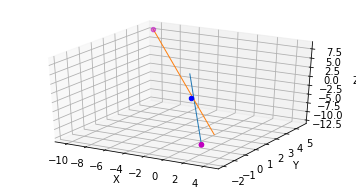

In [97]:
S = np.array([[3,0,0],[0,3,0]]).T
S = distribute_sensors(2,12,15)
# V = form_V(S,0.01,0.01)
V = form_V(S,0.05,0.05)
P = sensor_proj(V)
P0 = P[:,:,0]
P1 = P[:,:,1]
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
plot_pointing_vectors(ax,S,V)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_aspect('equal')

ax.scatter(0,0,0,c='b')
plt.show()

In [99]:
u0 = P0 @ [0,0,0,1]
u0 /= u0[2]
print(u0)
u1 = P1 @ [0,0,0,1]
u1 /= u1[2]
print(u1)

triangulate_l1(u0,u1,P0,P1)

[ 3.46944695e-18 -1.38777878e-17  1.00000000e+00]
[-0.00000000e+00  5.55111512e-17  1.00000000e+00]


array([ 4.46003979e-17, -3.70725569e-17, -2.82622091e-16])

In [106]:
tgt = np.zeros(3)
n_sensors = 10
S = distribute_sensors(n_sensors,15,25)

# Noise characteristics
a = np.array([1,0,0])
b = np.array([0,1,0])
sig_a = .2
sig_b = .1

V = form_V(S,sig_a,sig_b,a,b)

y,_,mse = kalman_simple(S,V,a,b,sig_a,sig_b)
print('Kalman Solution:', y)
print('Kalman MSE:', mse[-1])
est,_ = ls_triangulate(S,V)
print('Least Squares Solution:', est)
lstsq_mse = la.norm(est)**2 / 3
print('Least Squares MSE:', lstsq_mse)

Kalman Solution: [ 2.77565069e-17  8.87531497e-19 -2.26605540e-16]
Kalman MSE: 1.7373760698336266e-32
Least Squares Solution: [-2.36590226 -0.02538389  3.04865792]
Least Squares MSE: 4.964150984618569


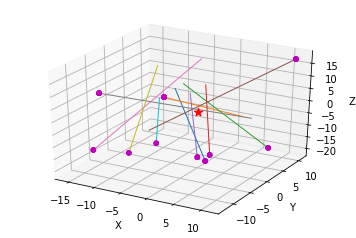

In [107]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
plot_pointing_vectors(ax,S,V)
ax.scatter(tgt[0],tgt[1],tgt[2],c='r',s=75,marker='*',zorder=0)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

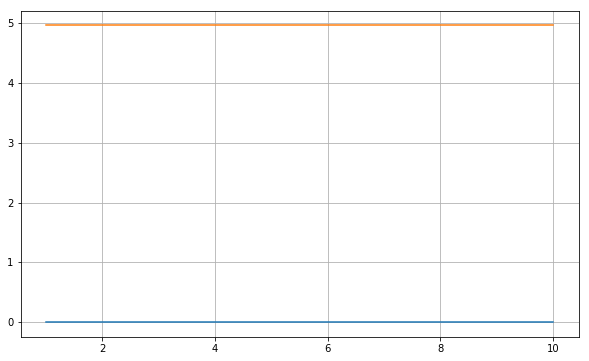

In [108]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(np.linspace(1,n_sensors,n_sensors),mse)
ax.plot([1,n_sensors],[lstsq_mse,lstsq_mse])
ax.axis('tight')
ax.grid(True)